# Setting up Enviornment

In [1]:
!pip install --upgrade ultralytics
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.9

# Dataset Download from Roboflow API

In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="RbA8rOJvkm0XmjH94940")
project = rf.workspace("weeddetection-f7llv").project("weed_d")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to weed_d-1 in yolov8:: 100%|██████████| 6598/6598 [00:01<00:00, 4968.40it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Dataset Exploration

In [3]:
import os
dataset_path = "/kaggle/working/weed_d-1"  
print("Dataset contents:", os.listdir(dataset_path))
print("Valid folder contents:", os.listdir(os.path.join(dataset_path, "valid")))

Dataset contents: ['README.dataset.txt', 'data.yaml', 'train', 'valid', 'README.roboflow.txt', 'test']
Valid folder contents: ['labels', 'images']


In [4]:
import os
train_path = os.path.join(dataset_path, "train", "images")
val_path = os.path.join(dataset_path, "valid", "images")
test_path = os.path.join(dataset_path, "test", "images")

print("Train images:", len(os.listdir(train_path)))
print("Validation images:", len(os.listdir(val_path)))
print("Test images:", len(os.listdir(test_path)))

Train images: 2877
Validation images: 278
Test images: 138


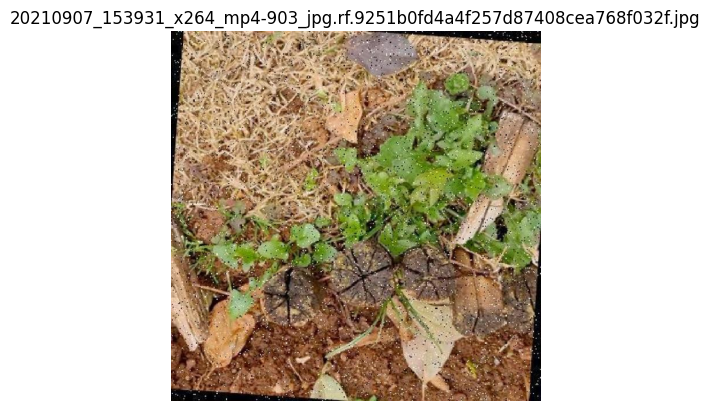

In [5]:
import cv2
import matplotlib.pyplot as plt
import random

def show_random_image(image_folder):
    image_files = os.listdir(image_folder)
    random_image = random.choice(image_files)
    image_path = os.path.join(image_folder, random_image)

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.axis("off")
    plt.title(random_image)
    plt.show()

# Display a sample image from training data
show_random_image(train_path)

In [6]:
label_path = os.path.join(dataset_path, "train", "labels")
random_label_file = random.choice(os.listdir(label_path))

with open(os.path.join(label_path, random_label_file), "r") as file:
    print(file.read())


0 0.709375 0.20546875 0.03359375 0.03125
0 0.76328125 0.22734375 0.040625 0.040625
0 0.76796875 0.38359375 0.0265625 0.0359375
0 0.446875 0.5671875 0.10078125 0.09140625
0 0.05078125 0.60703125 0.071875 0.05078125


In [7]:
from collections import Counter

class_counts = Counter()
for label_file in os.listdir(label_path):
    with open(os.path.join(label_path, label_file), "r") as file:
        for line in file:
            class_id = line.split()[0]  
            class_counts[class_id] += 1

print("Class Distribution:", class_counts)

Class Distribution: Counter({'0': 7834})


When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


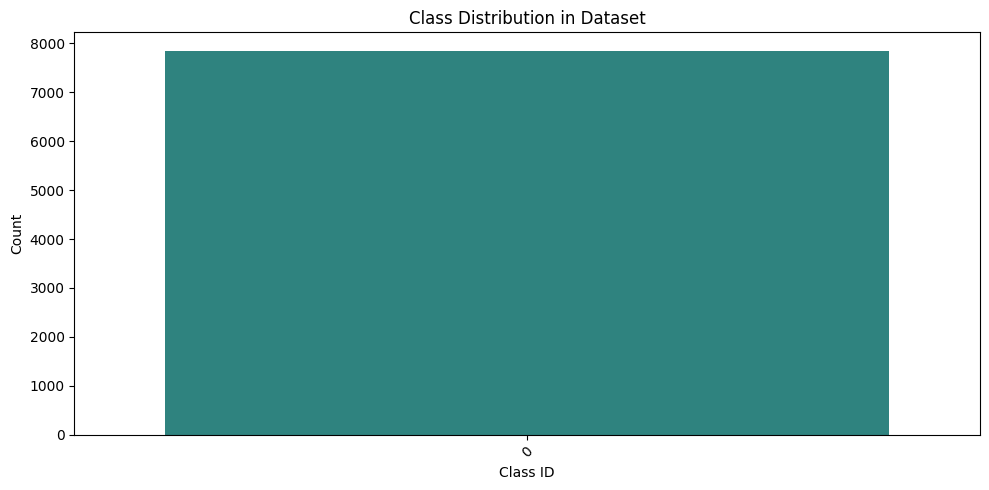

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

classes, counts = zip(*class_counts.items())

# Create a DataFrame
df = pd.DataFrame({
    "Class": classes,
    "Count": counts
})

plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="Class", y="Count", palette="viridis")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.title("Class Distribution in Dataset")
plt.xticks(rotation=45)  
plt.tight_layout()
plt.show()


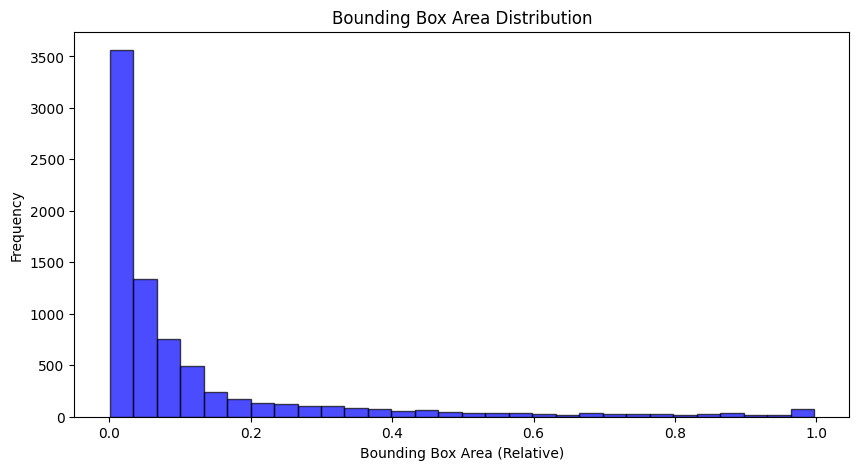

In [9]:
import numpy as np

bbox_areas = []

for label_file in os.listdir(label_path):
    with open(os.path.join(label_path, label_file), "r") as file:
        for line in file:
            _, x_center, y_center, width, height = map(float, line.split())
            area = width * height  # YOLO format uses relative coordinates
            bbox_areas.append(area)

plt.figure(figsize=(10, 5))
plt.hist(bbox_areas, bins=30, color="blue", alpha=0.7, edgecolor="black")
plt.xlabel("Bounding Box Area (Relative)")
plt.ylabel("Frequency")
plt.title("Bounding Box Area Distribution")
plt.show()


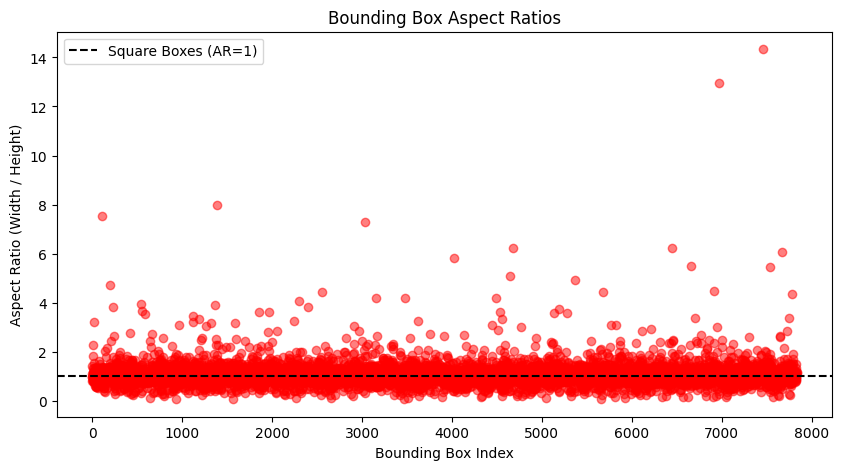

In [10]:
aspect_ratios = []

for label_file in os.listdir(label_path):
    with open(os.path.join(label_path, label_file), "r") as file:
        for line in file:
            _, x_center, y_center, width, height = map(float, line.split())
            aspect_ratio = width / height
            aspect_ratios.append(aspect_ratio)

plt.figure(figsize=(10, 5))
plt.scatter(range(len(aspect_ratios)), aspect_ratios, alpha=0.5, color="red")
plt.axhline(y=1, color="black", linestyle="--", label="Square Boxes (AR=1)")
plt.xlabel("Bounding Box Index")
plt.ylabel("Aspect Ratio (Width / Height)")
plt.title("Bounding Box Aspect Ratios")
plt.legend()
plt.show()


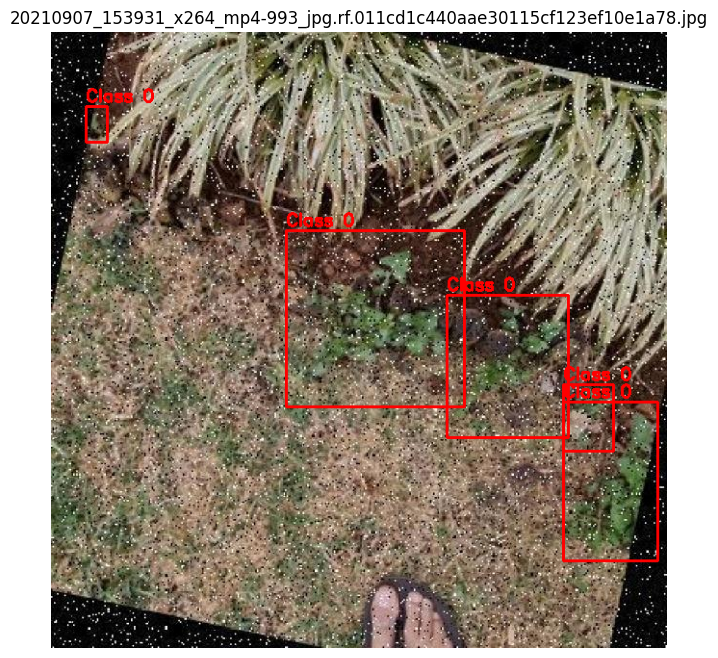

In [11]:
import cv2
import matplotlib.pyplot as plt
import random

image_folder = os.path.join(dataset_path, "train", "images")
label_folder = os.path.join(dataset_path, "train", "labels")

random_image_name = random.choice(os.listdir(image_folder))
image_path = os.path.join(image_folder, random_image_name)

label_file = os.path.join(label_folder, random_image_name.replace(".jpg", ".txt").replace(".png", ".txt"))


image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = image.shape  # Get image dimensions

if os.path.exists(label_file):
    with open(label_file, "r") as file:
        for line in file:
            class_id, x_center, y_center, width, height = map(float, line.split())

            # Converting YOLO format to pixel values
            x1 = int((x_center - width / 2) * w)
            y1 = int((y_center - height / 2) * h)
            x2 = int((x_center + width / 2) * w)
            y2 = int((y_center + height / 2) * h)

            # Drawing bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(image, f"Class {int(class_id)}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# Showing image with bounding boxes
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")
plt.title(random_image_name)
plt.show()


# Making data_yaml ready for Training

Dataset Training

In [12]:
data_yaml = """
names:
- Weeds
nc: 1
roboflow:
  license: CC BY 4.0
  project: weed_d
  url: https://universe.roboflow.com/weeddetection-f7llv/weed_d/dataset/1
  version: 1
  workspace: weeddetection-f7llv
train: /kaggle/working/weed_d-1/train/images
val: /kaggle/working/weed_d-1/valid/images
test: /kaggle/working/weed_d-1/test/images
"""

with open(os.path.join(dataset_path, "data.yaml"), "w") as f:
    f.write(data_yaml)

print("data.yaml updated successfully!")

data.yaml updated successfully!


# Training

In [13]:
from ultralytics import YOLO

model = YOLO("yolov8s.pt")

model.train(
    data=os.path.join(dataset_path, "data.yaml"),
    epochs=30,
    imgsz=640,
    augment=True,
    hsv_h=0.015,    
    hsv_s=0.7,      
    hsv_v=0.8,      
    degrees=10,     
    translate=0.1,  
    scale=0.7,      
    shear=5.0,      
    perspective=0.002,  
    flipud=0.2,     
    fliplr=0.5,     
    mosaic=1.0,     
    erasing=0.4,    
)

100%|██████████| 21.5M/21.5M [00:00<00:00, 340MB/s]


Ultralytics 8.3.120 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/weed_d-1/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

100%|██████████| 755k/755k [00:00<00:00, 46.5MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 163MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1970.5±368.5 MB/s, size: 130.6 KB)


train: Scanning /kaggle/working/weed_d-1/train/labels... 2877 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2877/2877 [00:01<00:00, 1525.92it/s]


train: New cache created: /kaggle/working/weed_d-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 504.7±254.7 MB/s, size: 114.2 KB)


val: Scanning /kaggle/working/weed_d-1/valid/labels... 278 images, 0 backgrounds, 0 corrupt: 100%|██████████| 278/278 [00:00<00:00, 1842.25it/s]

val: New cache created: /kaggle/working/weed_d-1/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.32G      1.887      2.255      2.018         60        640: 100%|██████████| 180/180 [01:15<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.96it/s]

                   all        278        714      0.479      0.395      0.389      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.32G      1.698      1.768      1.874         59        640: 100%|██████████| 180/180 [01:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.60it/s]

                   all        278        714      0.537      0.393      0.408      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.32G      1.682      1.747      1.885         66        640: 100%|██████████| 180/180 [01:18<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]

                   all        278        714      0.587      0.487      0.531      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.33G      1.607      1.655      1.829         99        640: 100%|██████████| 180/180 [01:10<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.11it/s]

                   all        278        714      0.661      0.577      0.636      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      4.33G      1.575      1.579      1.788         59        640: 100%|██████████| 180/180 [01:18<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.76it/s]

                   all        278        714      0.746      0.675      0.752      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.33G      1.541      1.534      1.757         62        640: 100%|██████████| 180/180 [01:14<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.75it/s]

                   all        278        714      0.803      0.667      0.792      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.33G      1.502      1.458      1.719         72        640: 100%|██████████| 180/180 [01:17<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.74it/s]

                   all        278        714      0.756        0.7      0.771      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.33G      1.491      1.418      1.699         68        640: 100%|██████████| 180/180 [01:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.74it/s]

                   all        278        714      0.777      0.731      0.802      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.33G      1.449      1.387      1.685         76        640: 100%|██████████| 180/180 [01:21<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.18it/s]

                   all        278        714      0.785      0.681      0.766      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.33G      1.454      1.365      1.664         78        640: 100%|██████████| 180/180 [01:20<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

                   all        278        714       0.83      0.748      0.826      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.33G      1.439      1.313      1.651         68        640: 100%|██████████| 180/180 [01:18<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.96it/s]

                   all        278        714      0.852      0.733      0.819      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.33G      1.409      1.275      1.636         88        640: 100%|██████████| 180/180 [01:17<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.24it/s]

                   all        278        714      0.836      0.789      0.855       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.33G      1.405      1.256      1.631         54        640: 100%|██████████| 180/180 [01:14<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.09it/s]

                   all        278        714      0.885      0.768      0.869      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.33G      1.411      1.241      1.619         79        640: 100%|██████████| 180/180 [01:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.13it/s]

                   all        278        714        0.9      0.779       0.88      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.33G      1.387      1.201      1.597         88        640: 100%|██████████| 180/180 [01:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.85it/s]

                   all        278        714      0.885      0.795      0.885      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.33G      1.369      1.167      1.588         73        640: 100%|██████████| 180/180 [01:12<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.85it/s]

                   all        278        714      0.875      0.804      0.889      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.33G      1.358      1.156      1.575         69        640: 100%|██████████| 180/180 [01:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.51it/s]

                   all        278        714       0.88       0.82      0.898       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.33G       1.33      1.123       1.56         76        640: 100%|██████████| 180/180 [01:19<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.54it/s]

                   all        278        714      0.872      0.836        0.9      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.33G      1.319      1.117      1.546         86        640: 100%|██████████| 180/180 [01:12<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.01it/s]

                   all        278        714      0.904       0.82      0.903      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.33G      1.318        1.1      1.556         73        640: 100%|██████████| 180/180 [01:12<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]

                   all        278        714      0.885      0.836      0.901      0.448


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.33G      1.343      0.996      1.616         27        640: 100%|██████████| 180/180 [01:12<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.85it/s]

                   all        278        714        0.9      0.846      0.926      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.33G      1.315     0.8973      1.581         46        640: 100%|██████████| 180/180 [01:10<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.09it/s]

                   all        278        714      0.904       0.86      0.937      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.33G       1.29     0.8752      1.563         28        640: 100%|██████████| 180/180 [01:09<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.82it/s]

                   all        278        714      0.911      0.846      0.922      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.33G      1.281     0.8571      1.546         26        640: 100%|██████████| 180/180 [01:20<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]

                   all        278        714      0.916      0.891      0.945      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.33G      1.241     0.8135      1.519         68        640: 100%|██████████| 180/180 [01:13<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.75it/s]

                   all        278        714      0.933       0.87      0.947      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.33G      1.236     0.7864      1.498         17        640: 100%|██████████| 180/180 [01:14<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.51it/s]

                   all        278        714      0.915      0.882      0.954      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.33G      1.203     0.7602      1.482         37        640: 100%|██████████| 180/180 [01:10<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.88it/s]

                   all        278        714      0.899      0.898      0.944      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.33G      1.187     0.7454      1.466         28        640: 100%|██████████| 180/180 [01:12<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.71it/s]

                   all        278        714      0.932      0.878      0.952      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.33G      1.176     0.7283      1.456         30        640: 100%|██████████| 180/180 [01:11<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]

                   all        278        714      0.927      0.901       0.96      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      4.33G      1.167     0.7139      1.451         30        640: 100%|██████████| 180/180 [01:13<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.01it/s]

                   all        278        714      0.912      0.908       0.96      0.553



30 epochs completed in 0.654 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.120 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


                   all        278        714      0.905      0.867      0.953      0.616


invalid value encountered in less
invalid value encountered in less


Speed: 1.2ms preprocess, 15.4ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x781c384ad3d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 